Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('data/text8.zip', 31344016)

Found and verified data/text8.zip


Read the data into a string.

In [4]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [5]:
VOCABULARY_SIZE = 50000


def build_dataset(words):
  count = [('UNK', -1)]
  count.extend(collections.Counter(words).most_common(VOCABULARY_SIZE - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0
      unk_count += 1
    data.append(index)
  count[0] = (count[0][0], unk_count)
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample Data', data[:10])
print('Sample Words', words[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [('UNK', 418391), ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample Data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]
Sample Words ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


Function to generate a training batch for the skip-gram model.

In [22]:
data_index = 0

def generate_batch_skip_gram(batch_size, num_skips, skip_window):
  """
  For each skip, selected a target and context associated with it.
  :param batch_size:
  :param num_skips:
  :param skip_window:
  :return:
  """
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1
  buffr = collections.deque(maxlen=span)
  for _ in range(span):
    buffr.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in xrange(batch_size // num_skips):
    target = skip_window
    targets_to_avoid = [skip_window]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffr[skip_window]
      labels[i * num_skips + j] = buffr[target]
    buffr.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])


def _demo_generate_batch_skip_gram():
  for num_skips, skip_window in [(2, 1), (4, 2)]:
      global data_index
      data_index = 0
      batch, labels = generate_batch_skip_gram(batch_size=8, num_skips=num_skips, skip_window=skip_window)
      print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
      print('    batch:', [reverse_dictionary[bi] for bi in batch])
      print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

_demo_generate_batch_skip_gram()

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'originated', 'term', 'a', 'of', 'originated', 'term', 'as']


Train a skip-gram model.

In [14]:
def skip_gram():
  batch_size = 128
  embedding_size = 128  # Dimension of the embedding vector.
  skip_window = 1  # How many words to consider left and right.
  num_skips = 2  # How many times to reuse an input to generate a label.
  # We pick a random validation set to sample nearest neighbors. here we limit the
  # validation samples to the words that have a low numeric ID, which by
  # construction are also the most frequent.
  valid_size = 16  # Random set of words to evaluate similarity on.
  valid_window = 100  # Only pick dev samples in the head of the distribution.
  valid_examples = np.array(random.sample(range(valid_window), valid_size))
  num_sampled = 64  # Number of negative examples to sample.

  graph = tf.Graph()

  with graph.as_default(), tf.device('/cpu:0'):
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
      tf.random_uniform([VOCABULARY_SIZE, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
      tf.truncated_normal([VOCABULARY_SIZE, embedding_size],
                          stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([VOCABULARY_SIZE]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
      tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                 labels=train_labels, num_sampled=num_sampled, num_classes=VOCABULARY_SIZE))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

  num_steps = 100001

  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    average_loss = 0
    for step in range(num_steps):
      batch_data, batch_labels = generate_batch_skip_gram(batch_size, num_skips, skip_window)
      feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
      _, l = session.run([optimizer, loss], feed_dict=feed_dict)
      average_loss += 1
      if step % 2000 == 0:
        if step > 0:
          average_loss /= 2000
        # The average loss is an estimate of the loss over the last 2000 batches.
        print('Average loss at step %d: %f' % (step, average_loss))
        average_loss = 0
      if step % 10000 == 0:
        sim = similarity.eval()
        for i in range(valid_size):
          valid_word = reverse_dictionary[valid_examples[i]]
          top_k = 8
          nearest = (-sim[i, :]).argsort()[1:top_k + 1]
          log = 'Nearest to %s:' % valid_word
          for k in range(top_k):
            close_word = reverse_dictionary[nearest[k]]
            log = '%s %s,' % (log, close_word)
          print(log)
    evaluated_embeddings = normalized_embeddings.eval()
  return evaluated_embeddings

In [16]:
final_embeddings = skip_gram()

Initialized
Average loss at step 0: 1.000000
Nearest to known: predicates, unqualified, productive, offshoots, afx, parent, suisse, btu,
Nearest to states: saud, leak, kingman, sod, cheeks, sanctuaries, superficial, monetarist,
Nearest to many: shifting, brunel, buyer, traders, aaas, fabled, chalcedon, destination,
Nearest to his: modernization, bodybuilding, baptiste, vhs, persuaded, stilgar, exiles, mapped,
Nearest to UNK: befitting, dandies, cosimo, reformation, persisted, negri, abuse, shoulders,
Nearest to however: attaches, goldwater, denominated, administratives, quay, vow, profane, registries,
Nearest to during: solutions, perkins, ncs, spiritually, bey, zyklon, genovese, spun,
Nearest to some: courier, alimony, motor, orpheus, basements, harmattan, leads, barefoot,
Nearest to on: kmaq, cochran, potsdamer, commercially, mushrooms, escapes, ingesting, colchis,
Nearest to up: congenital, milius, self, considerable, alkaloid, soteriology, rugrats, taper,
Nearest to can: complexion

In [17]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

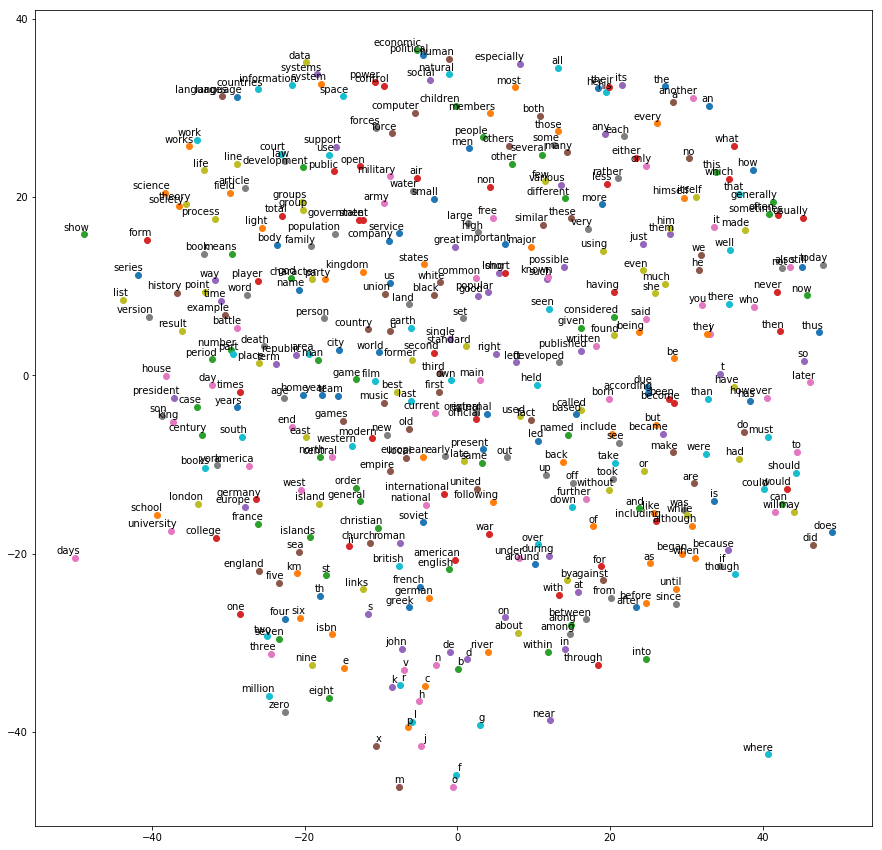

In [18]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [23]:
def generate_batch_cbow(batch_size, window_length):
  global data_index
  span = 2 * window_length + 1
  batch = np.ndarray((batch_size, span - 1), np.int32)
  labels = np.ndarray((batch_size, 1), np.int32)
  buffr = collections.deque(maxlen=span)
  for _ in range(span):
    buffr.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in xrange(batch_size):
    buffr_lst = list(buffr)
    labels[i, 0] = buffr_lst.pop(window_length)
    batch[i] = buffr_lst
    buffr.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels


def _demo_generate_batch_cbow():
  for window_length in [1, 2]:
    global data_index
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, window_length=window_length)
    print('\nwith window_length = %d' % window_length)
    print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

_demo_generate_batch_cbow()


with window_length = 1
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with window_length = 2
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [25]:
def cbow():
  batch_size = 128
  embedding_size = 128  # Dimension of the embedding vector.
  window_length = 2  # Length of one side of a window when selecting context.
  valid_size = 16  # Random set of words to evaluate similarity on.
  valid_window = 100  # Only pick dev samples in the head of the distribution.
  valid_examples = np.array(random.sample(range(valid_window), valid_size))
  num_sampled = 64  # Number of negative examples to sample.

  graph = tf.Graph()

  with graph.as_default(), tf.device('/cpu:0'):
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, 2 * window_length])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
      tf.random_uniform([VOCABULARY_SIZE, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
      tf.truncated_normal([VOCABULARY_SIZE, embedding_size],
                          stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([VOCABULARY_SIZE]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
      tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=tf.reduce_sum(embed, 1),
                                 labels=train_labels, num_sampled=num_sampled, num_classes=VOCABULARY_SIZE))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

  num_steps = 100001

  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    average_loss = 0
    for step in range(num_steps):
      batch_data, batch_labels = generate_batch_cbow(batch_size, window_length=window_length)
      feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
      _, l = session.run([optimizer, loss], feed_dict=feed_dict)
      average_loss += 1
      if step % 2000 == 0:
        if step > 0:
          average_loss /= 2000
        # The average loss is an estimate of the loss over the last 2000 batches.
        print('Average loss at step %d: %f' % (step, average_loss))
        average_loss = 0
      if step % 10000 == 0:
        sim = similarity.eval()
        for i in range(valid_size):
          valid_word = reverse_dictionary[valid_examples[i]]
          top_k = 8
          nearest = (-sim[i, :]).argsort()[1:top_k + 1]
          log = 'Nearest to %s:' % valid_word
          for k in range(top_k):
            close_word = reverse_dictionary[nearest[k]]
            log = '%s %s,' % (log, close_word)
          print(log)
    evaluated_embeddings = normalized_embeddings.eval()
  return evaluated_embeddings

Initialized
Average loss at step 0: 1.000000
Nearest to six: observables, bassoon, compel, dissension, relevance, endosymbionts, omit, scales,
Nearest to on: etch, fatou, poke, months, artistically, appel, childbearing, octavia,
Nearest to united: disinfectant, tooth, trucks, chromodynamics, academia, dalnet, heating, forgiving,
Nearest to seven: boundary, sulla, diametrically, volley, medication, comrades, faith, breaching,
Nearest to to: reassure, pepper, escort, going, soloists, facilitated, trilemma, browne,
Nearest to he: womb, sicily, bodmin, armenians, henderson, kib, soleil, prayed,
Nearest to its: wasps, validated, langer, jealousy, magee, pups, reviving, cia,
Nearest to more: cams, rv, jag, loudspeakers, crusaders, slipped, sierra, nizam,
Nearest to many: servicemen, racecar, ibadi, ig, lapd, ansi, desi, compatriots,
Nearest to state: customer, cin, pathologies, kilowatts, dramatized, adapters, rheingold, dedekind,
Nearest to have: plummeted, gx, duvall, strunk, announced, le

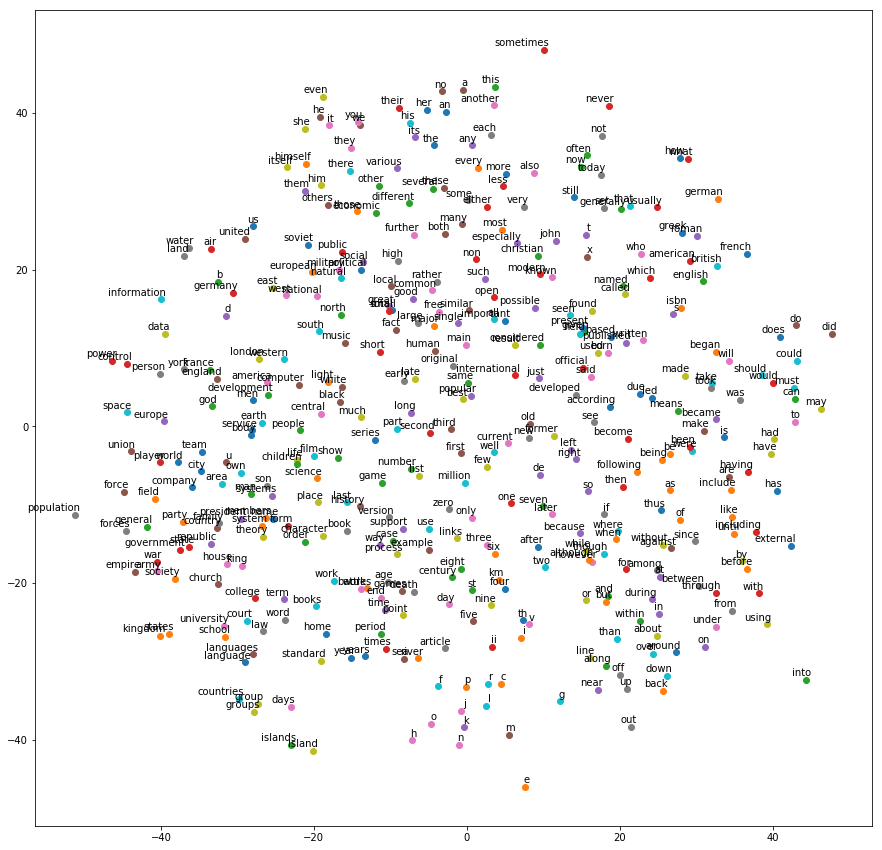

In [26]:
final_embeddings = cbow()
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points + 1, :])
words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)